# World Health Organization mortality data

The World Health Organization (WHO) assimilates and harmonizes
mortality data for most countries in the world.  These data include
"all cause" (total) mortality, as well as cause-specific mortality
(e.g. mortality due to cancer).  Here we will focus on the all-cause
mortality data, for a subset of countries with data that are mostly
complete.

The data considered were obtained from the site below, which also
provides documentation about the data.

https://www.who.int/data/data-collection-tools/who-mortality-database

Many important research efforts involve analysis of this type of
data.  In general, mortality has declined over the past 100 years,
but it has declined much faster in some regions and within some
demographic subgroups than in others.  Also, mortality due to some
causes has declined much faster than others.

It usually makes sense to compare death rates (mortality relative to
population), which is a proportion, rather than the absolute number
of deaths, since the number of deaths is strongly related to the
underlying population size.  The WHO reports both the number of
people who die within each demographic group per country/year, and
the population sizes of these groups.  We can form a proportion from
these two numbers.  Here, a demographic group is defined by an age
band (e.g. 70-75 years) and sex (female or male).

We will focus here on the use of Z-scores for comparing proportions.
Suppose we have two proportions derived from data, $\hat{p}$ and
$\hat{q}$, representing the proportions of women and men between 70
and 75 who die each year.  These proportions have population
analogues $p$ and $q$ that we do not know.  The best possible
measure of the difference in sex-specific death rates is $p-q$, and
the "plug-in" estimate of this quantity is $\hat{p} - \hat{q}$.

Since $\hat{p} - \hat{q}$ is an estimate, it has an error associated
with it, whose typical size is quantified by the standard error.
The standard error here is $\sqrt{p(1-p)/m + q(1-q)/n}$, where $m$
and $n$ are the sample sizes for women and men, respectively.  Again
we "plug-in" the estimates of $p$ and $q$ and obtain an estimated
standard error $\sqrt{\hat{p}(1-\hat{p})/m + \hat{q}(1-\hat{q})/n}$.

Finally, we can obtain the Z-score, which as always is an estimate
divided by its (estimated) standard error.

$(\hat{p}-\hat{q}) / \sqrt{\hat{p}(1-\hat{p})/m +
\hat{q}(1-\hat{q})/n}$.

A Z-score is a measure of evidence that $p$ and $q$ are different.
Observing a value of Z close to zero indicates no evidence for a
difference.  Specifically, if Z is smaller than 2 in absolute value,
there is no meaningful evidence for a difference, under the standard
conventions for gauging evidence.

Here we will study Z-scores for several types of mortality rate
comparisons, including comparisons between the sexes, and
comparisons over time within sexes.

First, we import the libraries that we will need.

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

Modify this string according to your section number (001 or 002):

In [2]:
f = "stats206s002f21"

Next we read the dataset into a dataframe.

In [3]:
base = "/scratch/%s_class_root/%s_class/shared_data/datasets" % (f, f)
df = pd.read_csv(os.path.join(base, "who_allcause.csv.gz"))
df.head()

,Country,Year,Sex,Age,Deaths,Pop
0,2090,2000,1.0,1,111741.0,15246964.0
1,2090,2000,2.0,1,106320.0,15543870.0
2,2090,2001,1.0,1,112000.0,15364404.0
3,2090,2001,2.0,1,107537.0,15656847.0
4,2090,2002,1.0,1,113266.0,15538572.0


In a few instances, there must be a problem with the data since the
number of reported deaths is greater than the reported population.
This is very rare so we drop these few rows of data.

In [4]:
df = df.loc[df["Deaths"] <= df["Pop"], :]

# Comparing death rates by sex

In almost all settings, death rates for males are greater than death
rates for females.  Here we will study the relationship between the
female and male death rates.

The original data are in long form (one row per demographic cell /
country / year).  We need to "pivot" on sex, so that the mortality
counts and population sizes for women and men are in the same row,
for a given age band, country, and year.  We do that by splitting
the data by sex, then merging the files for women and for men.

First, select only the women.  We also rename some of the columns to
make the column names unique.

In [5]:
da_f = df.loc[df.Sex == 2, :]
da_f = da_f.rename(columns={"Pop": "Pop_f", "Deaths": "Deaths_f"})
da_f = da_f.drop(["Sex"], axis=1)
da_f.head()

,Country,Year,Age,Deaths_f,Pop_f
1,2090,2000,1,106320.0,15543870.0
3,2090,2001,1,107537.0,15656847.0
5,2090,2002,1,110337.0,15834015.0
7,2450,1999,1,1215939.0,139414254.0
9,2450,2000,1,1225773.0,143368343.0


Now, select only the men and perform the same renaming as above.

In [6]:
da_m = df.loc[df.Sex == 1, :]
da_m = da_m.rename(columns={"Pop": "Pop_m", "Deaths": "Deaths_m"})
da_m = da_m.drop(["Sex"], axis=1)
da_m.head()

,Country,Year,Age,Deaths_m,Pop_m
0,2090,2000,1,111741.0,15246964.0
2,2090,2001,1,112000.0,15364404.0
4,2090,2002,1,113266.0,15538572.0
6,2450,1999,1,1175460.0,133276559.0
8,2450,2000,1,1177578.0,138053563.0


Now we can do the merge, aligning by country, year, and age.

In [7]:
v = ["Country", "Year", "Age"]
dx = pd.merge(da_m, da_f, left_on=v, right_on=v)
dx.head()

,Country,Year,Age,Deaths_m,Pop_m,Deaths_f,Pop_f
0,2090,2000,1,111741.0,15246964.0,106320.0,15543870.0
1,2090,2001,1,112000.0,15364404.0,107537.0,15656847.0
2,2090,2002,1,113266.0,15538572.0,110337.0,15834015.0
3,2450,1999,1,1175460.0,133276559.0,1215939.0,139414254.0
4,2450,2000,1,1177578.0,138053563.0,1225773.0,143368343.0


Next we calculate the death rates (note that these are proportions):

In [8]:
dx["drate_f"] = dx["Deaths_f"] / dx["Pop_f"]
dx["drate_m"] = dx["Deaths_m"] / dx["Pop_m"]
dx.head()

,Country,Year,Age,Deaths_m,Pop_m,Deaths_f,Pop_f,drate_f,drate_m
0,2090,2000,1,111741.0,15246964.0,106320.0,15543870.0,0.006840,0.007329
1,2090,2001,1,112000.0,15364404.0,107537.0,15656847.0,0.006868,0.007290
2,2090,2002,1,113266.0,15538572.0,110337.0,15834015.0,0.006968,0.007289
3,2450,1999,1,1175460.0,133276559.0,1215939.0,139414254.0,0.008722,0.008820
4,2450,2000,1,1177578.0,138053563.0,1225773.0,143368343.0,0.008550,0.008530


Before proceeding, let's see what we can learn by exploring the
death rates.  First we make a boxplot showing how the female death
rates vary by age.  Recall that the numerical age values represent
age bands, see the documentation for the exact age ranges.  The main
insight here is that the death rate is higher for older people.

<AxesSubplot:xlabel='Age', ylabel='drate_f'>

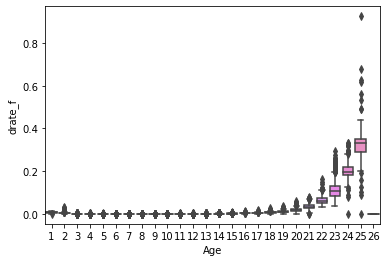

In [9]:
sns.boxplot(x="Age", y="drate_f", data=dx)

Sometimes a transformation reveals something that is otherwise
hidden.  Below we make a boxplot of the square-root transformed
proportions, and see that mortality is somewhat greater for very
young children, compared to older children and young adults.

<AxesSubplot:xlabel='Age', ylabel='drate_f_sqrt'>

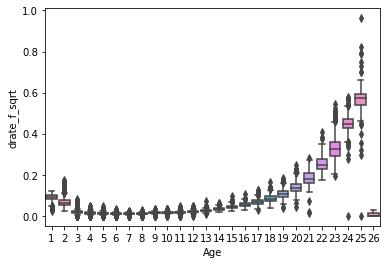

In [10]:
dx["drate_f_sqrt"] = np.sqrt(dx["drate_f"])
sns.boxplot(x="Age", y="drate_f_sqrt", data=dx)

Next we make a scatterplot of the male death rates (vertical axis)
against the female death rates (horizontal axis).  The trend
(correlation) between female and male death rates reflects the fact
that the countries and years with higher death rate tend to have
higher death rates for both sexes.  Nevertheless, there are some
instances where the female and male death rates diverge.  We will
return to this further below.

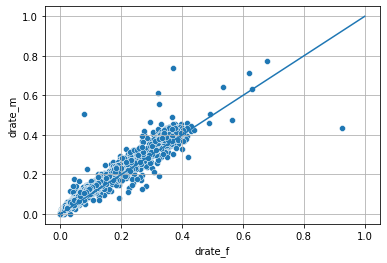

In [11]:
plt.grid(True)
sns.scatterplot(x="drate_f", y="drate_m", data=dx)
plt.plot([0, 1], [0, 1], '-')

A useful plot in this setting is a "mean/difference plot", sometimes
called a "volcano plot".  This is a plot of the average of two
quantities against their difference.  One observation we make here
is that the instances where the female and male death rates are very
different are all instances where the mean death rate is quite
large.  This plot also makes it easy to see that it is more common
that the male death rate exceeds the female death rate.

<AxesSubplot:xlabel='drate_diff', ylabel='drate_mean'>

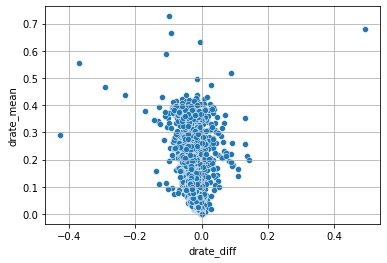

In [12]:
dx["drate_diff"] = dx["drate_f"] - dx["drate_m"]
dx["drate_mean"] = (dx["drate_f"] + dx["drate_m"]) / 2
plt.grid(True)
sns.scatterplot(x="drate_diff", y="drate_mean", data=dx)

## Analyses considering statistical evidence and uncertainty

Now we turn to an analysis that more completely considers the
uncertainty in the data.  The key for understanding uncertainty is
almost always the standard error.  To make it easier to calculate
the standard error, we define variables containing the key terms in
the standard error: p is the estimated death rate for females, q is
the estimated death rate for males, m is the sample size for
females, and n is the sample size for males.  Note that all four of
these quantities are vectors containing results for various
countries and years.  The data are aligned so that for an index i,
p[i], q[i], m[i], and n[i] all correspond to the same country and
year.

In [13]:
p = dx["drate_f"]
q = dx["drate_m"]
m = dx["Pop_f"]
n = dx["Pop_m"]

Below we calculate the Z-score for the difference in death rates
between women and men.

In [14]:
dx["zdiff"] = (p - q) / np.sqrt(p*(1-p)/m + q*(1-q)/n)
dx.head()

,Country,Year,Age,Deaths_m,Pop_m,Deaths_f,Pop_f,drate_f,drate_m,drate_f_sqrt,drate_diff,drate_mean,zdiff
0,2090,2000,1,111741.0,15246964.0,106320.0,15543870.0,0.006840,0.007329,0.082704,-0.000489,0.007084,-16.164560
1,2090,2001,1,112000.0,15364404.0,107537.0,15656847.0,0.006868,0.007290,0.082876,-0.000421,0.007079,-13.988630
2,2090,2002,1,113266.0,15538572.0,110337.0,15834015.0,0.006968,0.007289,0.083477,-0.000321,0.007129,-10.683622
3,2450,1999,1,1175460.0,133276559.0,1215939.0,139414254.0,0.008722,0.008820,0.093390,-0.000098,0.008771,-8.669721
4,2450,2000,1,1177578.0,138053563.0,1225773.0,143368343.0,0.008550,0.008530,0.092465,0.000020,0.008540,1.818552


A Z-score comparing two proportions is primarily influenced by three
factors: (i) the difference between the underlying probabilities,
i.e. $p - q$, (ii) the sample sizes $m$ and $n$, (iii) whether
either or both of $p$ and $q$ are close to the boundary points 0 and
1.

The following relationships hold, where $p$ and $q$ are the
population death rates.  Don't worry about what numerical values
correspond to "small" here.  The purpose is to recognize these
important relationships.

* If $p - q$ is zero then the $Z$ score will tend to be small, no matter how large the sample sizes are.
* If $p - q$ is small but not zero, then $Z$ will tend to be small unless $m$ and $n$ are very large.
* If $p - q$ is moderate-large, then $Z$ may still be small if the sample sizes are small.
* If $p - q$ is moderate-large and the sample sizes $m$ and $n$ are both not small, then $Z$ will generally be moderate-large.

Point (iii) above is slightly more subtle, but for proportions, it
is easier to establish that $p$ and $q$ are different if one of them
is closer to 0 or 1.

The boxplots below show the distribution of Z-scores comparing
female to male death rates by country, focusing on instances where
the sample size is small (less than 50,000).  The boxes reflect the
data for multiple years within each country, considering people of
ages 70-75 only.  Since most of the Z-scores are around 2 or less
(in magnitude) we see that in instances where we have fewer than
10,000 total people, there usually is not strong evidence for a
difference between the female and male death rates.  As noted above,
this could be because there truly is no difference in the
population, or because the sample size is too small for us to be
able to discern a difference.  The one exception here is country
4160 (Iceland), where there is strong evidence for greater mortality
among males than among females, in spite of the sample sizes being
small.

<AxesSubplot:xlabel='Country', ylabel='zdiff'>

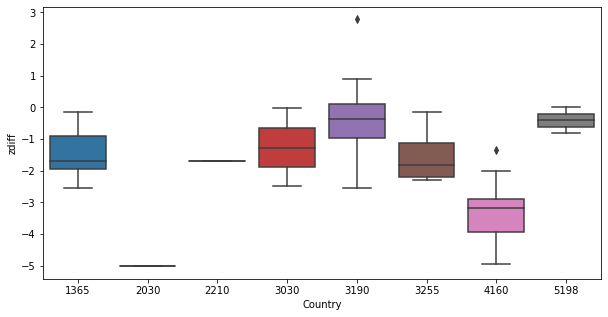

In [15]:
plt.figure(figsize=(10, 5))
dz = dx.loc[dx["Age"] == 20, :]
dz = dz.loc[dz["Pop_f"] + dz["Pop_m"] < 10000, :]
sns.boxplot(x="Country", y="zdiff", data=dz)

Now let's look at the analogous plot for instances where the sample
size is quite large.

<AxesSubplot:xlabel='Country', ylabel='zdiff'>

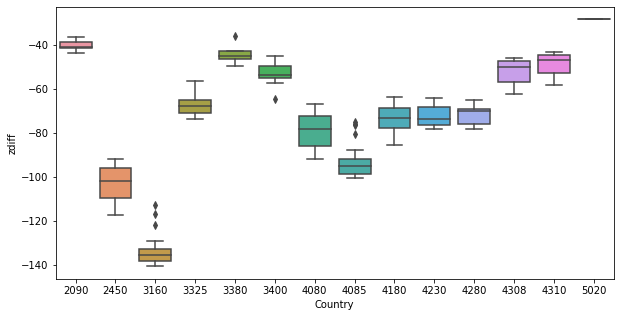

In [16]:
plt.figure(figsize=(10, 5))
dz = dx.loc[dx["Age"] == 20, :]
dz = dz.loc[dz["Pop_f"] + dz["Pop_m"] > 1000000, :]
sns.boxplot(x="Country", y="zdiff", data=dz)

Above it is clear that there is always strong evidence that
mortality varies by sex, as long as we have data for more than one
million people.  The scatterplot below shows how the Z-scores vary
with sample size.  When the sample size is large, the Z-scores are
always strongly negative, indicating strong evidence that male
mortality is greater than female mortality.

<AxesSubplot:xlabel='logpop', ylabel='zdiff'>

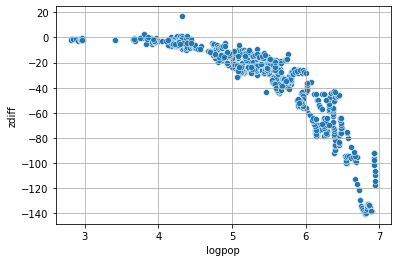

In [17]:
dz = dx.loc[dx.Age == 20, :].copy()
dz["logpop"] = np.log10(dz["Pop_f"] + dz["Pop_m"])
plt.grid(True)
sns.scatterplot(x="logpop", y="zdiff", data=dz)

The plot above shows that consistently large Z-scores occur as long
as the sample size is around 10,000 or greater.  There is
uncertainty about whether mortality truly varies by sex for the
smaller subgroups.  In general, if we collect a single dataset and
observe, say, Z=-1, then this would not be seen as evidence for a
difference.  But here, we have many related datasets (for different
years and countries), and sex-specific differences are always
present when the sample size is large.  While it is possible that
the small subgroups are fundamentally different than the larger
subgroups, and in the small subgroups there actually is no
difference between female and male mortality, it seems more likely
that sex differences in mortality exist in nearly all settings, but
we lack power to detect them when the sample size is small.

We can also consider whether the evidence for sex-differences in
mortality differs across the ages.  The boxplot below shows that
there is strong evidence that males have higher mortality than
females in every age band.  Even the magnitude of this evidence does
not vary much with age.

<AxesSubplot:xlabel='Year', ylabel='zdiff'>

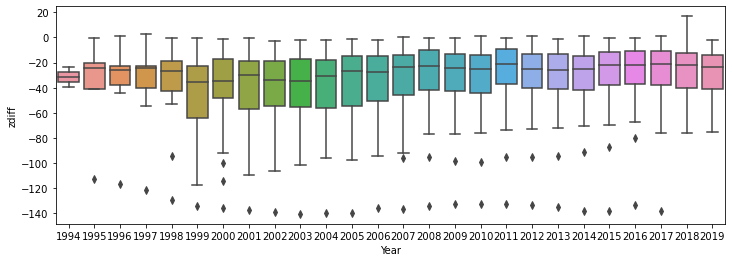

In [18]:
plt.figure(figsize=(12, 4))
sns.boxplot(x="Year", y="zdiff", data=dz)

__Note on very large Z-scores:__ Z-scores are mainly used to
quantify evidence that two things are different, here the difference
being between two proportions $p$ and $q$.  Z-scores larger than,
say, 5 (in magnitude) constitute "overwhelming evidence" that the
difference is real.  Once overwhelming evidence is observed, it is
no longer very relevant exactly how large the Z-score is.  For
example, it is questionable whether a Z-score of 20 should be
treated as being much stronger than a Z-sore of 5.  But there is no
doubt that a Z-score of 3 is stronger than a Z-score of 2.

# Comparing death rates over time

Next we examine death rates over time, and specifically how the
death rate compares between two different years, for each sex, age
band, and country.

We will focus on people who are 70-75 years old:

In [19]:
dz = df.loc[df.Age == 20, :]
dz.head()

,Country,Year,Sex,Age,Deaths,Pop
5196,2090,2000,1.0,20,15074.0,455876.0
5197,2090,2000,2.0,20,10338.0,546067.0
5198,2090,2001,1.0,20,14748.0,469331.0
5199,2090,2001,2.0,20,10190.0,549999.0
5200,2090,2002,1.0,20,14614.0,479597.0


These are the two years that we will compare:

In [20]:
year1 = 2009
year2 = 2010

Here we select the data for the first year of interest:

In [21]:
da = dz.loc[dz.Year == year1, :]
da = da.rename(columns={"Pop": "Pop1", "Deaths": "Deaths1"})
da = da.drop(["Year"], axis=1)

Here we select the data for the second year of interest:

In [22]:
db = dz.loc[dz.Year == year2, :]
db = db.rename(columns={"Pop": "Pop2", "Deaths": "Deaths2"})
db = db.drop(["Year"], axis=1)

Now we merge the datasets for the two years to form a wide-form
dataset.

In [23]:
v = ["Country", "Sex", "Age"]
dz = pd.merge(da, db, left_on=v, right_on=v)

Next we calculate the death rates for the two years of interest.

In [24]:
dz["rate1"] = dz["Deaths1"] / dz["Pop1"]
dz["rate2"] = dz["Deaths2"] / dz["Pop2"]

Below we calculate the Z-scores comparing the death rates in two
years.

In [25]:
p = dz["rate1"]
q = dz["rate2"]
m = dz["Pop1"]
n = dz["Pop2"]
dz["zdiff"] = (p - q) / np.sqrt(p*(1-p)/m + q*(1-q)/n)

Now we plot the Z-scores against population.  You should explore
where statistical differences emerge by changing the values of
`year1` and `year2` above, and re-running the notebook.  You should
see statistically strong reductions in mortality when comparing two
years that are far apart, say 2000 and 2010, but much less evidence
for a difference when comparing, say, 2009 and 2010.  The reason for
this is that the improvement in mortality over 1 year is too small
to provide strong statistical evidence.

<AxesSubplot:xlabel='logpop', ylabel='zdiff'>

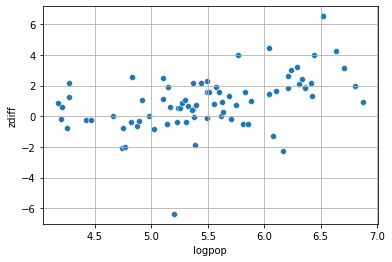

In [26]:
plt.grid(True)
dz["logpop"] = np.log10(dz["Pop1"] + dz["Pop2"])
plt.grid(True)
sns.scatterplot(x="logpop", y="zdiff", data=dz)

# Confidence intervals for death rates

Confidence intervals are a very useful way to communicate the level
of uncertainty about a statistical estimate.  The confidence
intervals that we use in this course are easily derived from a point
estimate and its standard error (not all confidence intervals are
derived this way, but in this course we always use this approach).
The 95% confidence interval (CI) for an estimate is equal to the
estimate plus or minus two times its standard error.

Confidence intervals can be constructed for a single target, or for
the difference between two targets.  In this notebook, the focus is
on mortality rates in specific locations, years, and demographic
subgroups.  For example, if we present the 95% confidence interval
for the mortality rate among 70-80 year old women living in
Argentina, this is a confidence interval for a single target.  On
the other hand, if we present the 95% confidence interval for the
difference between female and male mortality rates among 70-80 year
old people living in Argentina, then this is a confidence interval
for the difference between two targets.

Next we calculate the death rate and its estimated standard error
for each population subgroup (age group x year x country x sex).

In [27]:
df["drate"] = df["Deaths"] / df["Pop"]
df["drate_se"] = np.sqrt(df["drate"] * (1 - df["drate"]) / df["Pop"])

Now we calculate 95% confidence intervals in the usual way.

In [28]:
df["ucb"] = df["drate"] + 2*df["drate_se"]
df["lcb"] = df["drate"] - 2*df["drate_se"]
df.head()

,Country,Year,Sex,Age,Deaths,Pop,drate,drate_se,ucb,lcb
0,2090,2000,1.0,1,111741.0,15246964.0,0.007329,0.000022,0.007372,0.007285
1,2090,2000,2.0,1,106320.0,15543870.0,0.006840,0.000021,0.006882,0.006798
2,2090,2001,1.0,1,112000.0,15364404.0,0.007290,0.000022,0.007333,0.007246
3,2090,2001,2.0,1,107537.0,15656847.0,0.006868,0.000021,0.006910,0.006827
4,2090,2002,1.0,1,113266.0,15538572.0,0.007289,0.000022,0.007333,0.007246


Note that in a few instances, the confidence interval falls outside
the valid range for a probability.  This is something that can
happen with this type of confidence interval.

In [29]:
(df["lcb"] < 0).sum()

1403

Above we constructed a dataset 'dx' that placed the female and male
death rates in distinct dataframe columns.  We then looked at
Z-scores for differences between two targets, e.g.  female minus
male mortality in a specific age group, year, and country.  We can
now adapt these calculations to produce confidence intervals for the
difference between two rates (female minus male).  These are some of
the key quantities that we will need:

In [30]:
p = dx["drate_f"]
q = dx["drate_m"]
m = dx["Pop_f"]
n = dx["Pop_m"]

The estimated pooled standard error for the difference of rates is

In [31]:
dx["pse"] = np.sqrt(p*(1-p)/m + q*(1-q)/n)

Once we have the pooled standard error, we can construct a 95%
confidence interval for the difference between the female and male
death rates by taking the point estimate plus or minus two standard
errors.

In [32]:
dx["drate_diff"] = dx["drate_f"] - dx["drate_m"]
dx["lcb"] = dx["drate_diff"] - 2*dx["pse"]
dx["ucb"] = dx["drate_diff"] + 2*dx["pse"]

One of the important characteristics of a confidence interval is its
width.  A narrow confidence interval is more informative than a wide
confidence interval.  The width of a confidence interval is
influenced by several factors, including the sample size (or sample
sizes if there are two groups).

The plots below show how the width of the confidence intervals
constructed above relate to the sample sizes of the smaller and
larger of the two groups being compared.  We restrict to one of the
older age bands so that the death rate is not extremely small.

/sw/arcts/centos7/python3.8-anaconda/2021.05/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<AxesSubplot:xlabel='log_smaller_n', ylabel='log_ci_width'>

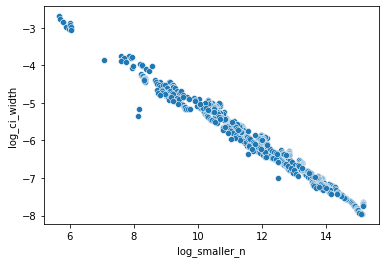

In [33]:
dx["log_ci_width"] = np.log(dx["ucb"] - dx["lcb"])
dx["log_smaller_n"] = np.log(dx[["Pop_m", "Pop_f"]].min(1))
dx["log_larger_n"] = np.log(dx[["Pop_m", "Pop_f"]].max(1))
dxx = dx.loc[dx["Age"] == 20, :]
sns.scatterplot(x="log_smaller_n", y="log_ci_width", data=dxx)

<AxesSubplot:xlabel='log_larger_n', ylabel='log_ci_width'>

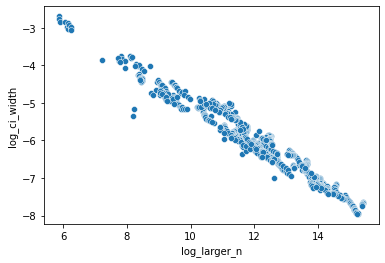

In [34]:
sns.scatterplot(x="log_larger_n", y="log_ci_width", data=dxx)

# Hypothesis tests

Another way to convey statistical uncertainty is by conducting a
formal hypothesis test.  This involves specifying a null hypothesis,
devising a test statistic that measures evidence against the null,
and calculating a p-value that conveys the strength of evidence
against the null hypothesis on a standard scale.

Continuing with the analysis above, we will consider the formal
hypothesis that female and male mortality rates are equal in
individual subpopulations defined by age, country, and year.  This
is a two-sample t-test based on proportions.  The two sample
t-statistic is as follows.

In [35]:
dx["tstat"] = dx["drate_diff"] / dx["pse"]

The corresponding p-value for this test is as follows.

In [36]:
dx["pvalue"] = 2*scipy.stats.distributions.norm.cdf(-np.abs(dx["tstat"]))

Remember that a small p-value and a large (in magnitude) test
statistic convey evidence against the null hypothesis.  It is nearly
equivalent that the test statistic is greater than 2 in magnitude or
the p-value is less than 0.05.

In [37]:
print((np.abs(dx["tstat"]) > 2).mean())
print((dx["pvalue"] <= 0.05).mean())

0.7301113656951032
0.7329354718388661


The test statistic also contains information about the direction of
the effect that is lost when working with the p-value.  In this
analysis, since our estimand is the female death rate minus the male
death rate, a positive test-statistic corresponds to a setting where
female deaths are more common than male deaths (relative to the
population sizes).  A negative test statistic corresponds to a
setting where male deaths are more common than female deaths.  The
latter is much more common:

In [38]:
print((dx["tstat"] <= -2).sum())
print(((dx["tstat"] > -2) & (dx["tstat"] <= 2)).sum())
print((dx["tstat"] > 2).sum())

13420
4903
282


The following plot shows how the p-values and test statistics are
related.  The p-value is extremely small unless the test statistic
is close to zero.

<AxesSubplot:xlabel='tstat', ylabel='pvalue'>

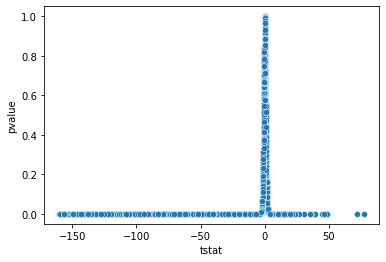

In [39]:
sns.scatterplot(x="tstat", y="pvalue", data=dx)

We can see this more clearly by zooming in on the origin.

(-10.0, 10.0)

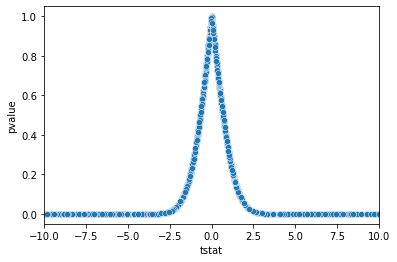

In [40]:
sns.scatterplot(x="tstat", y="pvalue", data=dx)
plt.xlim(-10, 10)